In [19]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import (
    Atlas, group_by_networks, plot_matrix, reshape_pvalues, block_block, plot_ordered_matrix
)
from bold_dementia.utils.iterables import unique

ATLAS = "schaeffer200"
SOFT = True
ALPHA = config["alpha"]
atlas = Atlas.from_name(ATLAS, soft=SOFT)

In [20]:
maps_path = Path(config['output_dir']) / f"connectivity/atlas-{ATLAS}_merged"

AD_matrices = joblib.load(maps_path / "AD.joblib")
control_matrices = joblib.load(maps_path / "control.joblib")
AD_df = pd.read_csv(maps_path / "balanced_AD.csv", index_col=0)
control_df = pd.read_csv(maps_path / "balanced_control.csv", index_col=0)[::23]
metadata = pd.concat((AD_df, control_df))

In [21]:
from matplotlib import colormaps

colors = colormaps["tab20"].colors

In [22]:
from bold_dementia.utils.iterables import unique
import itertools as it
cmapping = dict(zip(
    unique(atlas.macro_labels),
    colors
))

In [30]:
import networkx as nx


def plot_fc(arr_nonsparse, thresh=0.01):
    arr = np.where(abs(arr_nonsparse) < thresh, 0, arr_nonsparse)
    G = nx.from_numpy_array(arr)
    edge_values = [G.get_edge_data(u, v)["weight"] for u, v in G.edges()]
    edge_width = np.abs(edge_values)
    edge_color = ["blue" if v < 0 else "red" for v in edge_values]
    node_color = [cmapping[net] for net in atlas.macro_labels]
    
    pos = nx.spring_layout(G, seed=config["seed"])
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=edge_width, edge_color=edge_color)
    nx.draw_networkx_nodes(G, pos, node_color=node_color, alpha=0.4)
    return pos

In [29]:
cmapping

{'Vis': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'SomMot': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'DorsAttn': (1.0, 0.4980392156862745, 0.054901960784313725),
 'SalVentAttn': (1.0, 0.7333333333333333, 0.47058823529411764),
 'Limbic': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'Cont': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'Default': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)}

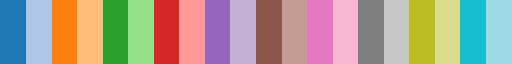

In [28]:
colormaps["tab20"]

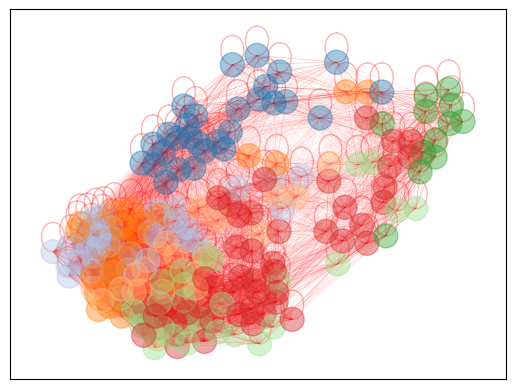

In [31]:
layout = plot_fc(control_matrices.mean(axis=0))

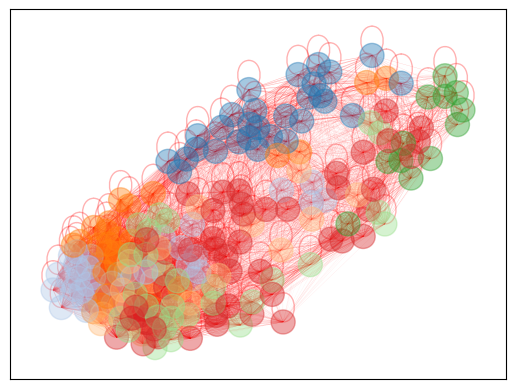

In [32]:
layout = plot_fc(AD_matrices.mean(axis=0))

In [8]:

def high_is_efficient(source, target, edge_attrs):
    """The more fc, the smaller the distance should be
    """
    w = edge_attrs["weight"]
    return abs(1/w)

def bin_fc(source, target, edge_attrs):
    w = edge_attrs["weight"]
    if w < 0.2:
        return np.inf
    else:
        return 1
        
from joblib import Parallel, delayed


def all_pairs_path_length(G, weight, n_jobs=1):
    length = nx.single_source_dijkstra_path_length
    parallel = Parallel(n_jobs=n_jobs, return_as="generator", verbose=5)
    calls = (delayed(length)(G, n, weight=weight) for n in G)
    return parallel(calls)

def all_pairs_path_length_serial(G, weight):
    """
    This function is going to be inside a joblib worker,
    so we can't use a generator
    """
    length = nx.single_source_dijkstra_path_length
    res = []
    for n in G:
        res.append(length(G, n, weight=weight))
    return res

def weighted_global_efficiency(G):

    n = len(G)
    denom = n * (n - 1)

    if denom == 0:
        return 0

    lengths = all_pairs_path_length_serial(
        G, weight=bin_fc
    )
    g_eff = 0
    for targets in lengths:
        # TODO Rewrite this loop in numpy
        for distance in targets.values():
            if distance > 0:
                g_eff += 1 / distance
    g_eff /= denom
    return g_eff

In [9]:
def run_computations(mat, label):

    #  TODO Make func for mat to graph
    mat = np.where(abs(mat) < 1e-1, 0, mat)
    indexer = list(range(len(mat)))
    mat[indexer, indexer] = 0 # Remove self loops
    H = nx.from_numpy_array(mat)

    return (
        weighted_global_efficiency(H),
        nx.average_clustering(H),
        nx.average_node_connectivity(H),
        label
    )
    
def efficiency(mats, label):
    parallel = Parallel(n_jobs=10, verbose=5, return_as="generator")
    calls = (delayed(run_computations)(mat, label) for mat in mats)
    yield from parallel(calls)
        
cols = ["eff", "clustering", "avg_conn", "label"]
c = pd.DataFrame(efficiency(control_matrices[::23], "MCI"), columns=cols)
a = pd.DataFrame(efficiency(AD_matrices, "AD"), columns=cols)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   13.1s
[Parallel(n_jobs=10)]: Done 111 out of 111 | elapsed:   21.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done 110 out of 110 | elapsed:   16.1s finished


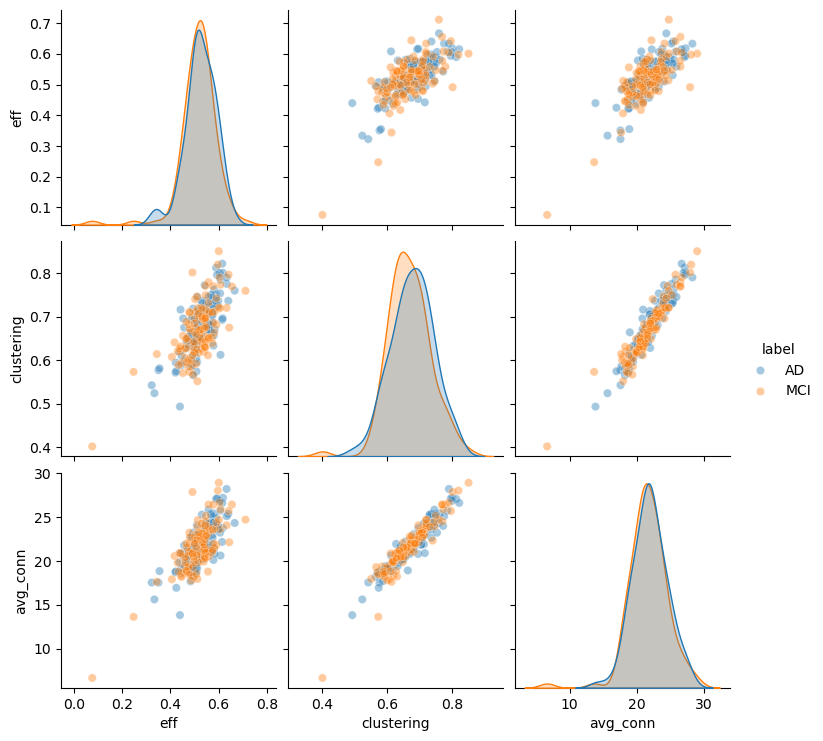

In [18]:
import seaborn as sns
df = pd.concat([a, c])
sns.pairplot(df, hue="label", plot_kws={"alpha": 0.4})
plt.show()

In [11]:
res = pd.merge(
    df,
    metadata,
    left_index=True,
    right_index=True
)

In [12]:
res.columns

Index(['eff', 'clustering', 'avg_conn', 'label', 'file_path', 'file_basename',
       'file_tag', 'file_type', 'file_fields', 'sub', 'ses', 'task', 'space',
       'res', 'desc', 'CEN_ANOM', 'NUM_ID', 'SEX', 'INCCONSDAT_D', 'AGE_CONS',
       'NIVETUD', 'MCI', 'CDRSCR', 'MA', 'DEMENCE_DAT', 'APOE_eps4',
       'APOE_geno', 'APOE_y', 'M000', 'M024', 'M048', 'current_scan_age',
       'scan_to_onset'],
      dtype='object')

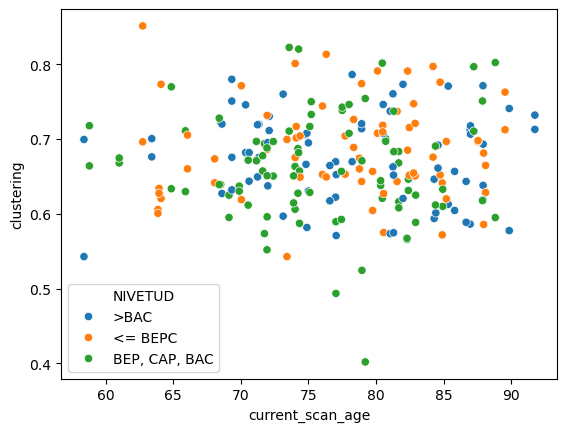

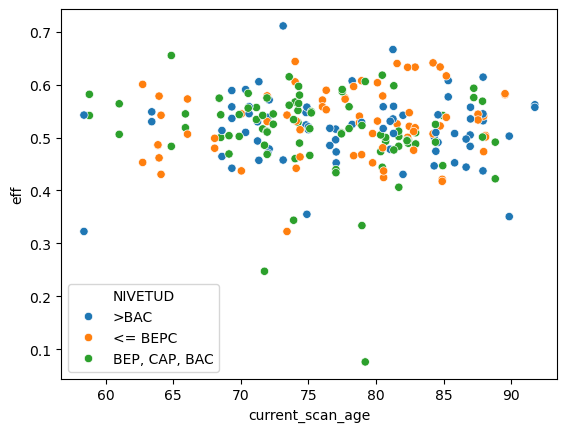

In [13]:
h = "NIVETUD"
sns.scatterplot(res, x="current_scan_age", y="clustering", hue=h)
plt.show()
sns.scatterplot(res, x="current_scan_age", y="eff", hue=h)
plt.show()